In [41]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using IterTools
using DelimitedFiles
include("../src/functions.jl")

avgAUC (generic function with 1 method)

# Population dynamics for the messages

In [3]:
Threads.nthreads()

40

In [28]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected
degreetype = "poisson"
d = 3 # degree 
T = 8 # discrete time
N = 5000; #population size
γ = 0.15
fr = 0.0
grid = 3

dilRange = LinRange(0.,0.5,2)
λRange = LinRange(0.01,0.4,grid) 
#folderstring = "./results/T=$(T)_d=$(d)_min=$(γvalues[1])_max=$(γvalues[end])_fr=$(fr)_dil=$(dil)/"

3-element LinRange{Float64, Int64}:
 0.01,0.205,0.4

In [36]:
function inf_vs_dil(γ, λRange, N, T, dist, paramdist, fr , dilRange ; tot_iterations = 1 )
    inf_out = zeros(length(λRange),length(dilRange), T + 2) # 1 value for pdiag and T+1 values for the AUC
    Threads.@threads for (λcount,dilcount) in collect(product(1:length(λRange),1:length(dilRange)))
        λi = λp = λRange[λcount]
        γi = γp = γ
        @show λi λp
        dilution = dilRange[dilcount]
        marg = pop_dynamics(N, T, λp, λi, γp, γi, dist, paramdist, tot_iterations = tot_iterations, fr=fr, dilution=dilution)
        marg2D = reshape((sum(marg,dims=1)./ N),T+2,T+2);
        # we sum over the trace of the 2D marginal to find the probability to infere correctly
        inf_out[λcount,dilcount,1] = sum([marg2D[t,t] for t=1:T+2])
        inf_out[λcount,dilcount,2:end] .= avgAUC(marg)
        #ProgressMeter.next!(pr)
    end
    return inf_out
end


inf_vs_dil (generic function with 1 method)

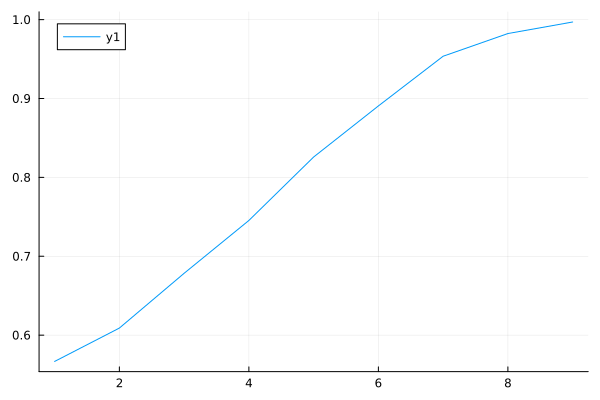

In [40]:
plot(inf_out[end,2,2:end])

In [37]:
inf_out = inf_vs_dil(γ, λRange, N, T, degreetype, d, fr , dilRange , tot_iterations = 10);

λi = 0.01
λp = 0.01
λi = 0.01
λp = 0.01
λi = 0.4
λp = 0.4
λi = 0.4
λp = 0.4
λi = 0.20500000000000002
λp = 0.20500000000000002
λi = 0.20500000000000002
λp = 0.20500000000000002


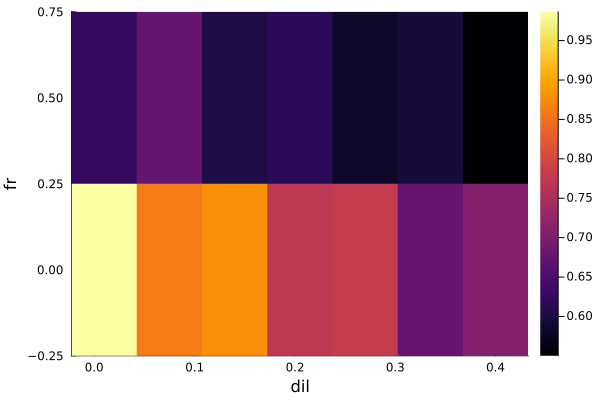

In [18]:
heatmap(λRange,dilRange,inf_out[:,:,2],ylabel="fr",xlabel="dil")